# Explore field collected soil spectra in Australia

In [1]:
import pandas as pd
import glob
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr

import sys
sys.path.append('/Users/Fangyuan/Documents/Projects/hyperspec-fc/unmixing')
from unmixing import remove_outliers
from unmixing import remove_outliers, smacc, qhull, nfindr 
from sklearn.decomposition import PCA

## Ausplot sites

In [2]:
base_path = '/Users/Fangyuan/FrontierSI/Projects - Documents/Projects - Data Analytics/130 Enhancing Fractional Cover Models Using Hyperspectral Data/4.1 Executing –  Working documents/hyperspec-fc-data/'

In [3]:
site_summary_file = f'{base_path}/TERN_EcoPlots/ausplot_site_summary_16042025.csv'
site_summary = pd.read_csv(site_summary_file)


In [4]:
site_summary.head()

,site_unique,site_location_name,established_date,description,bioregion_name,landform_pattern,landform_element,site_slope,site_aspect,comments,...,a_s_c,plot_is_100m_by_100m,plot_is_aligned_to_grid,plot_is_permanently_marked,latitude,longitude,point,state,visit_date,visit_number
0,NSABBS0001-58580,NSABBS0001,2018-05-11T10:11:00,"Warrumbungle National Park, 28.8km west of Coo...",BBS,HIL,FAN,3,45,Lower bottom slope of the range. 3 degree slop...,...,NaN,True,True,True,-31.281189,148.976552,SW,NSW,2018-05-11,1
1,NSABBS0002-58555,NSABBS0002,2018-05-12T13:41:09,Warrumbungle National Park. 893m north west of...,BBS,HIL,HSL,6,45,The Landform element is a hill slope with a pa...,...,NaN,True,True,True,-31.279453,148.992461,SW,NSW,2018-05-12,1
2,NSABBS0003-58581,NSABBS0003,2018-05-13T11:11:00,Pilliga State Conservation Area. 56.8km north ...,BBS,PLA,PLA,0,NaN,Site is flat. No surface strew or lithology ap...,...,NaN,True,False,True,-30.454647,149.226828,SW,NSW,2018-05-13,1
3,NSABBS0004-58556,NSABBS0004,2018-05-14T11:40:15,Pilliga State Conservation Area. 53.7km south ...,BBS,PLA,PLA,0,NaN,Landform element is a plain and pattern plain....,...,NaN,True,False,True,-30.460964,149.246894,SW,NSW,2018-05-14,1
4,NSABBS0005-58582,NSABBS0005,2018-05-15T12:06:00,Pilliga State Conservation Area. 52km south we...,BBS,PLA,PLA,0,NaN,The plot is inside Australian Wildlife Conserv...,...,NaN,True,False,True,-30.498783,149.279986,SW,NSW,2018-05-15,1


In [5]:
site_summary.nunique()

site_unique                   1003
site_location_name             787
established_date               699
description                    753
bioregion_name                  61
landform_pattern                17
landform_element                23
site_slope                      29
site_aspect                     51
comments                       779
outcrop_lithology               30
other_outcrop_lithology         20
plot_dimensions                 10
site_location_visit_id        1003
visit_start_date               903
visit_end_date                 902
visit_notes                    477
location_description           957
erosion_type                    11
erosion_abundance                7
erosion_state                    5
microrelief                     26
drainage_type                    7
disturbance                     10
climatic_condition               3
vegetation_condition             8
observer_veg                    28
observer_soil                   21
described_by        

## Soil spectra for QLD, NSW and VIC

In [6]:
# Downloaded soil files
soil_files = glob.glob(f"{base_path}/soil_spectra/*/*/*/TERN*.csv")+glob.glob(f"{base_path}/soil_spectra/*/*/*/TERN*.CSV")
len(soil_files)

243

In [7]:
site_names = [f.split('/')[-2] for f in soil_files]
matched = site_summary[site_summary.site_location_name.isin(site_names)]
# Keep the latest visit_date per site_location_name
matched = matched.sort_values('visit_date').drop_duplicates('site_location_name', keep='last')

In [8]:
matched.to_csv(f'{base_path}/TERN_EcoPlots/ausplot_site_summary_16042025_soil.csv')

### Match to soil type

In [9]:
map_file = f"{base_path}/Aus-Soil-Classification-Map/ASC_EV_C_P_AU_TRN_N.cog.tif"
soil_map = rxr.open_rasterio(map_file)

In [10]:
# Extract nearest values
values = []
for lat, lon in zip(matched['latitude'], matched['longitude']):
    val = soil_map.sel(x=lon, y=lat, method='nearest').item()
    values.append(val)

matched['soil_value'] = values

In [11]:
matched['soil_value'].describe()

count    234.000000
mean       6.059829
std        3.708917
min        1.000000
25%        2.000000
50%        7.000000
75%        8.000000
max       12.000000
Name: soil_value, dtype: float64

Text(0, 0.5, '# of sites')

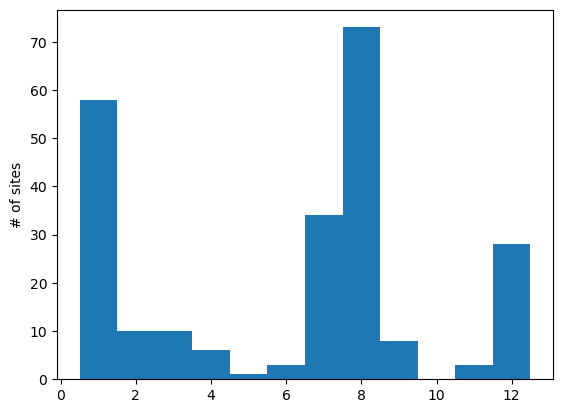

In [12]:
matched['soil_value'].plot.hist(bins =np.arange(0.5,matched['soil_value'].max()+1,1));
plt.ylabel('# of sites')

## Explore distribution of soil spectra

In [14]:
import re
from io import StringIO

def read_spectra(f):
    # Preprocess file
    with open(f, 'r') as fh:
        cleaned_lines = [re.sub(r'^"|"$', '', line.strip()) for line in fh]

    # Join and read via StringIO
    cleaned_data = '\n'.join(cleaned_lines)
    return pd.read_csv(StringIO(cleaned_data), sep=r'\s+|\t+', engine='python')

### Group by soil type

In [15]:
grouped = matched.groupby('soil_value')['site_location_name'].apply(list)

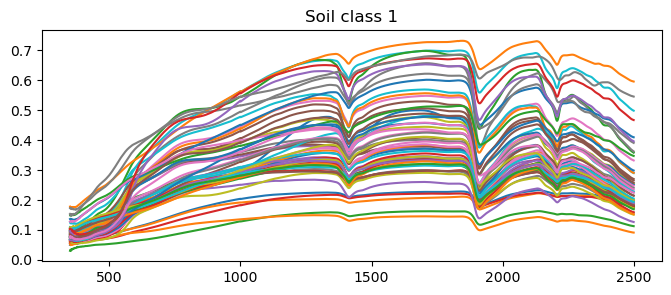

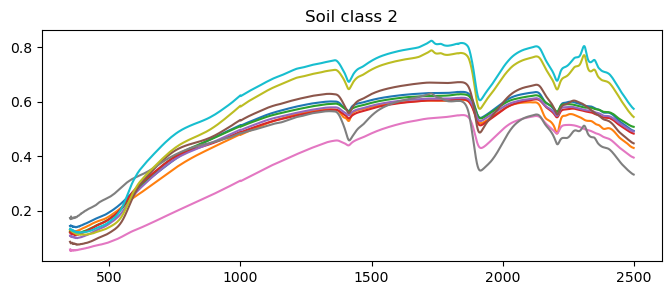

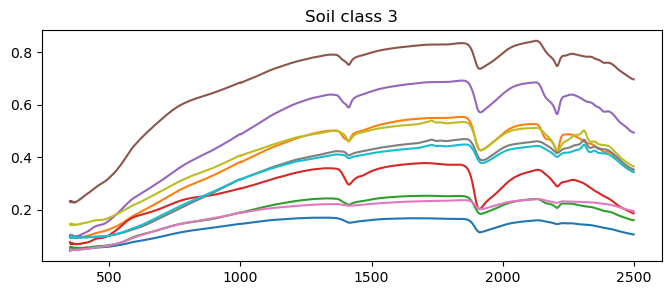

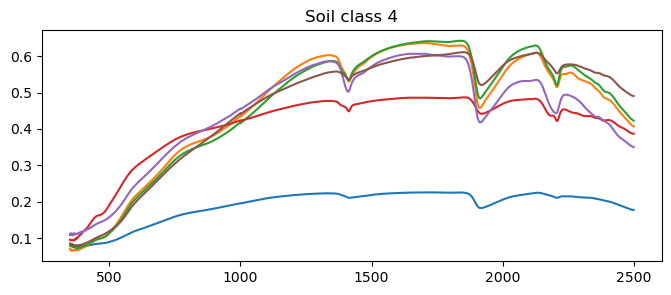

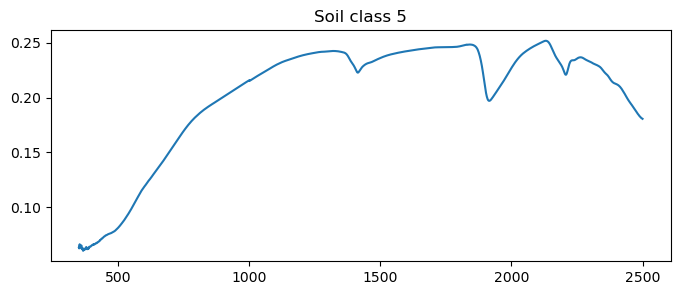

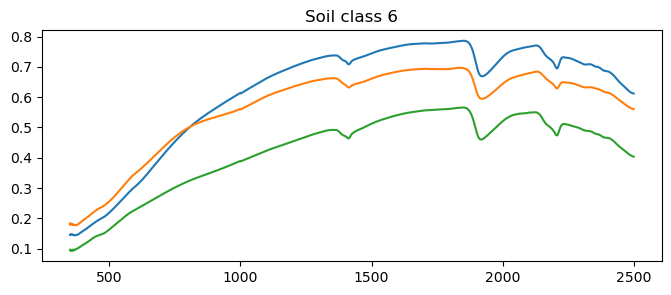

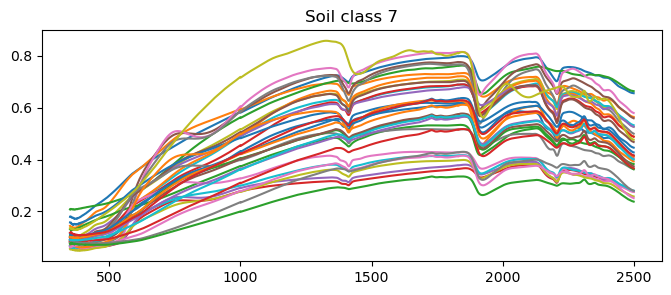

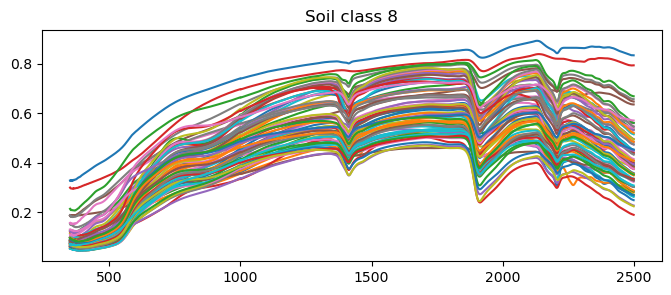

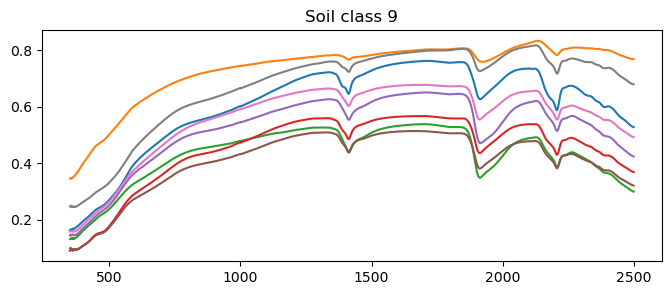

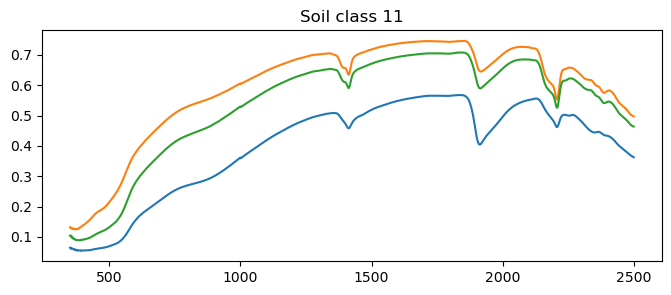

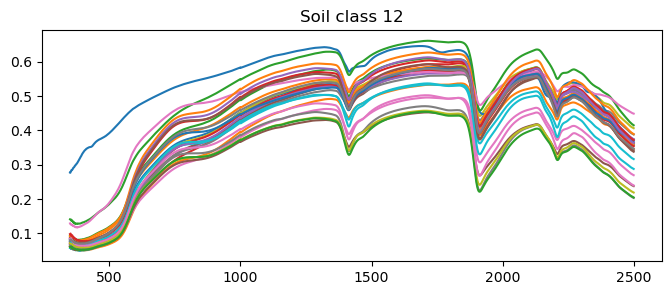

In [17]:
df_soil_group = pd.DataFrame({'Wavelength':[], 'Soil':[], 'Reflectance':[]})
soil_wavelengths = None

for soil_type in grouped.index:
    plt.figure(figsize=(8, 3))
    site_names = grouped.loc[soil_type]

    soil_group_stack = []
    for f in soil_files:
        site_name = f.split('/')[-2]
        if not site_name in site_names: continue
        
        df = read_spectra(f)
        # Melt the dataframe to have 'Wavelength' and 'Reflectance' in long format
        df_melted = df.melt(id_vars=['Wavelength'], var_name='Sample', value_name='Reflectance')
        mean = df_melted.groupby('Wavelength').Reflectance.mean()
        std = df_melted.groupby('Wavelength').Reflectance.std()
        plt.plot(mean.index, mean, label=site_name)
        #plt.fill_between(mean.index, mean - std, mean + std, alpha=0.3)

        # stack reflectance columns
        v_columns = [col for col in df.columns if not col.startswith('W')]
        if soil_wavelengths is None:
            soil_wavelengths = df['Wavelength'].values
            for col in v_columns: soil_group_stack.append(df[col])
        else:
            for col in v_columns: soil_group_stack.append(np.interp(soil_wavelengths, df['Wavelength'], df[col]))
    plt.title(f'Soil class {soil_type}')
    soil_group_stack = np.array(soil_group_stack)
    soil_group_mean = np.mean(soil_group_stack, axis=0)
    # Create a new DataFrame and append
    new_data = pd.DataFrame({
        'Wavelength': soil_wavelengths,
        'Soil': [f'Soil class {soil_type}']*len(soil_wavelengths),
        'Reflectance': soil_group_mean
    })
    df_soil_group = pd.concat([df_soil_group, new_data], ignore_index=True)


In [18]:
# Create the plot
fig = px.line(df_soil_group, x='Wavelength', y='Reflectance', color='Soil', title='Soil group mean spectra')
fig.show()

## Soil endmembers

In [19]:
soil_stack = []
soil_wavelengths = None
for f in soil_files:
    df = read_spectra(f)
    
    # Only select columns starting with 'V'
    v_columns = [col for col in df.columns if not col.startswith('W')]
    if soil_wavelengths is None:
        soil_wavelengths = df['Wavelength'].values
        for col in v_columns: soil_stack.append(df[col])
    else:
        for col in v_columns: soil_stack.append(np.interp(soil_wavelengths, df['Wavelength'], df[col]))


In [20]:
soil_stack = np.array(soil_stack)
soil_stack.shape

(7425, 2151)

In [21]:
cleaned_soil = remove_outliers(soil_stack)
cleaned_soil.shape

(7053, 2151)

In [22]:
pca = PCA(n_components=3)
pca_scores = pca.fit_transform(cleaned_soil)
# Pick spectra that lie furthest along each PC
endmember_idxs = [np.argmax(pca_scores[:, i]) for i in range(3)]
pca_endmembers = cleaned_soil[endmember_idxs]
# turn into dataframe
columns = [f'PCA SOIL{i+1}' for i in range(pca_endmembers.shape[0])]
pca_soil_df = pd.DataFrame(pca_endmembers.T, index=soil_wavelengths, columns=columns)

Cumulative PCA Explained Variance = [0.91871666 0.96674984 0.98774972]
Cumulative PCA Explained Variance = [0.91871666 0.96674984]


<Axes: >

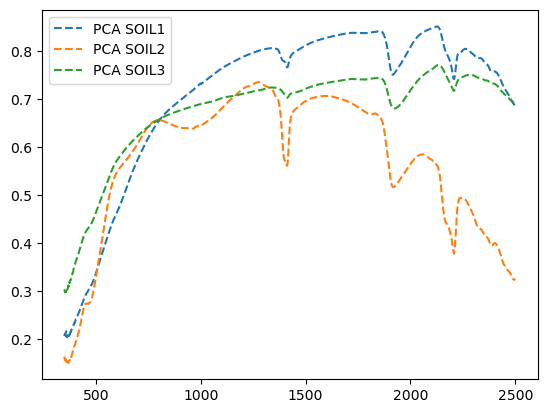

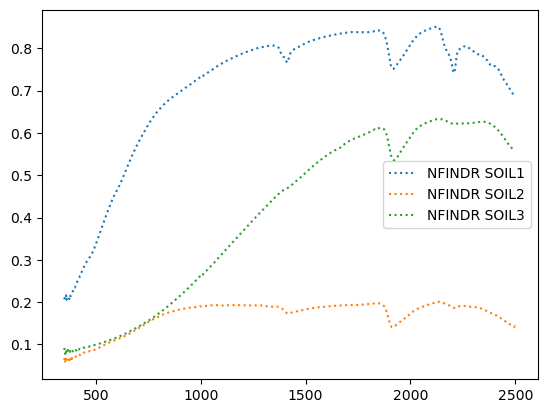

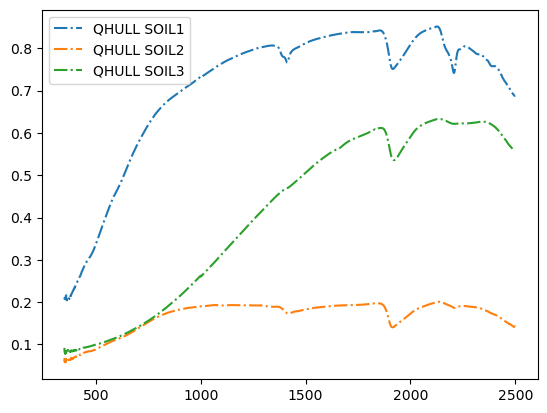

In [23]:
#from spectral.algorithms import nfindr
nfindr_endmembers = nfindr(cleaned_soil, 3)  # extract 3 endmembers
columns = [f'NFINDR SOIL{i+1}' for i in range(nfindr_endmembers.shape[0])]
nfindr_soil_df = pd.DataFrame(nfindr_endmembers.T, index=soil_wavelengths, columns=columns)

# Get endmembers for valid bands only
qhull_endmembers = qhull(cleaned_soil, 2)
columns = [f'QHULL SOIL{i+1}' for i in range(qhull_endmembers.shape[0])]
qhull_soil_df = pd.DataFrame(qhull_endmembers.T, index=soil_wavelengths, columns=columns)

pca_soil_df.plot(linestyle='--')
nfindr_soil_df.plot(linestyle=':')
qhull_soil_df.plot(linestyle='-.')

<Axes: >

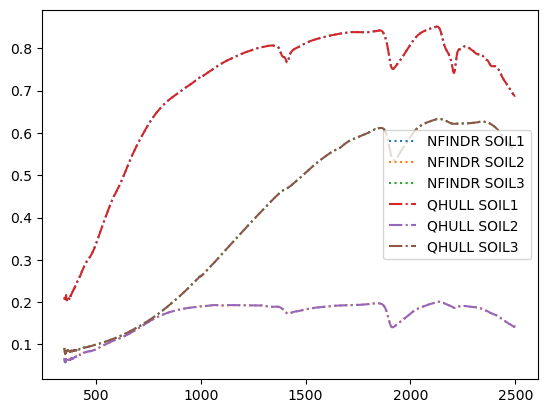

In [25]:
fig, ax = plt.subplots()

nfindr_soil_df.plot(linestyle=':', ax=ax)
qhull_soil_df.plot(linestyle='-.', ax=ax)

In [27]:
qhull_soil_df.to_csv('soil_members_qhull.csv')

### Unmixing test

In [43]:
from scipy.optimize import nnls

In [ ]:
# soil endmembers
endmembers = []
# replace soil endmember with typical soil
for col in qhull_soil_df.columns:
    endmembers.append(np.interp(soil_wavelengths, qhull_soil_df.index, qhull_soil_df[col]))
endmembers = np.array(endmembers)

# Setup inputs, outputs, and other configurations
sum_to_one = endmembers.shape[0]
weighted_endmembers = np.vstack((endmembers.T, np.ones(endmembers.shape[0]) * sum_to_one))

# unmix mean spectra
df_unmelted = df_soil_group.pivot(index='Soil', columns='Wavelength', values='Reflectance')
transformed = df_unmelted.values.T

# Precompute ones array outside the loop
ones_array = np.full((1, transformed.shape[1]), sum_to_one)

# Combine weighted reflectance with ones_array using np.vstack
weightedReflectance = np.vstack((transformed, ones_array))

# Initialize fractions array with zeros
fractions_nnls = np.zeros((weighted_endmembers.shape[1], transformed.shape[1]), dtype=np.float32)
# Use vectorization where possible
for i in range(weightedReflectance.shape[1]):
    fractions_nnls[:, i], _ = nnls(weighted_endmembers, weightedReflectance[:, i])


In [54]:
fractions_nnls.sum(axis=0)


array([1.0055877 , 0.9740263 , 1.002735  , 1.004713  , 0.9955965 ,
       0.9900467 , 0.9916062 , 0.99868846, 0.98892367, 0.98707795,
       1.0219619 ], dtype=float32)

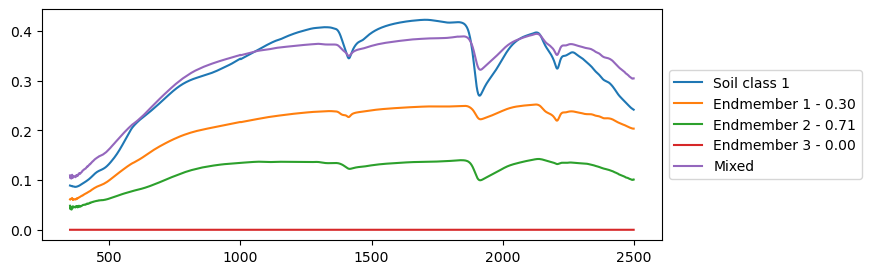

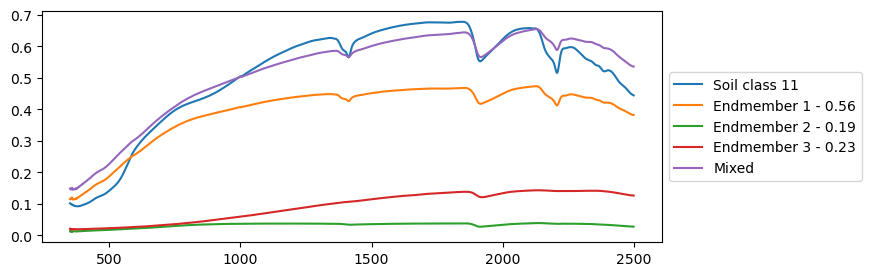

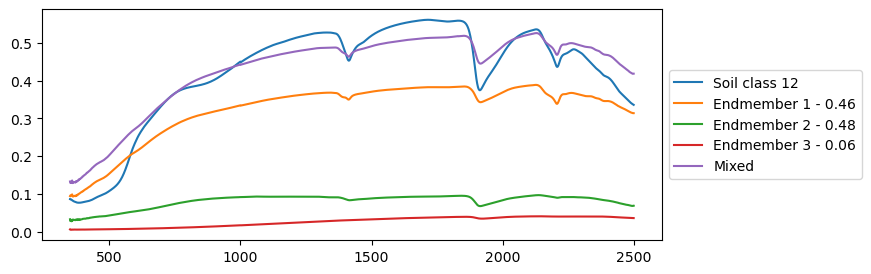

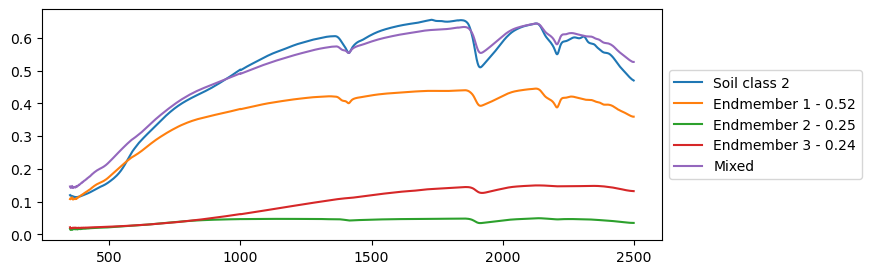

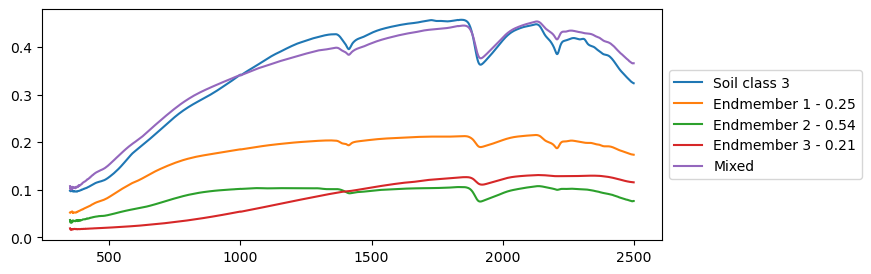

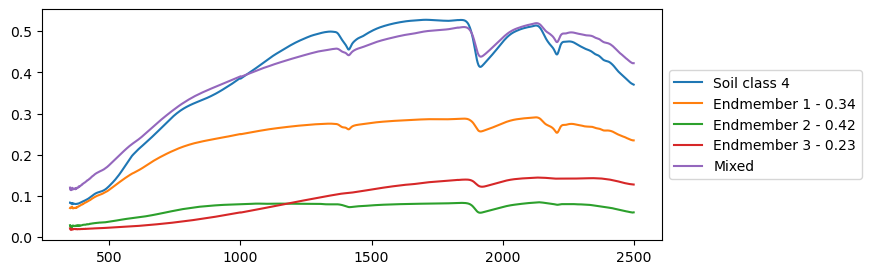

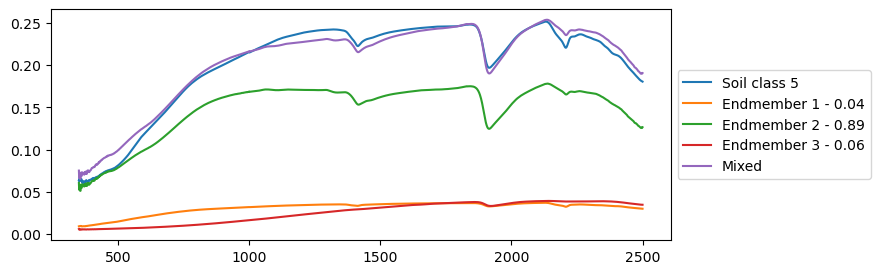

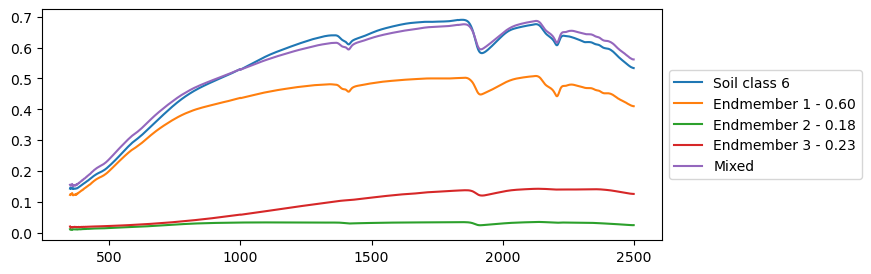

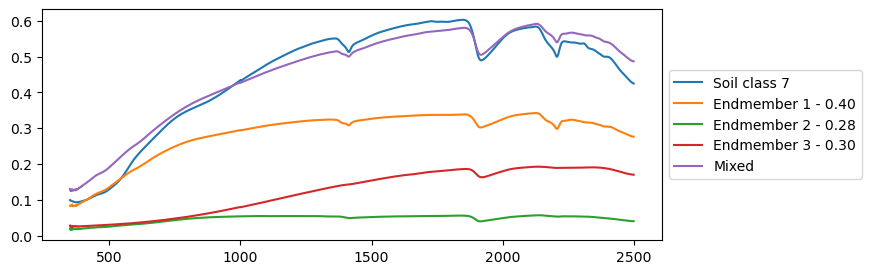

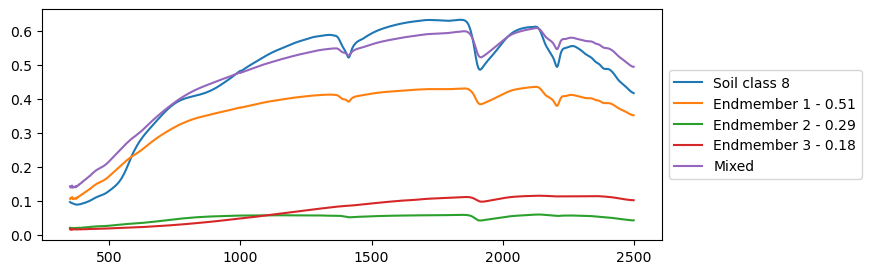

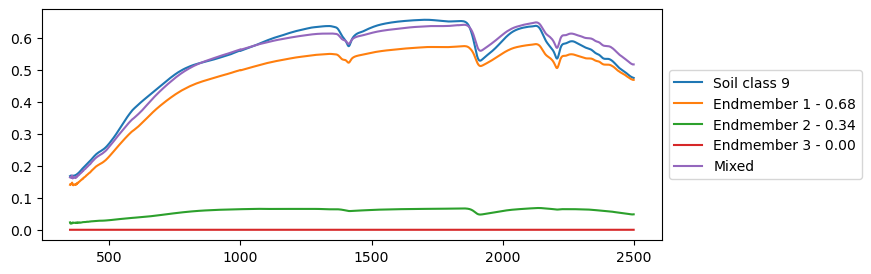

In [65]:
for idx in range(len(df_unmelted.index)):
    plt.figure(figsize=(8, 3))
    soil_type = df_unmelted.index[idx]
    E0 = endmembers.T
    plt.plot(soil_wavelengths, df_unmelted.loc[soil_type].values, label=soil_type)
    for i in range(fractions_nnls.shape[0]):
        if i==0: mixed = fractions_nnls[i, idx]*E0[:,i]
        else: mixed+= fractions_nnls[i, idx]*E0[:,i]
        plt.plot(soil_wavelengths, fractions_nnls[i, idx]*E0[:,i], label=f'Endmember {i+1} - {fractions_nnls[i, idx]:0.2f}')
    plt.plot(soil_wavelengths, mixed, label='Mixed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Use only selected wavelengths

In [67]:
# Define the valid wavelength ranges
bad_ranges = [(0, 440), (1310, 1490), (1770, 2050), (2440, 2880)]

# Function to check if a wavelength is outside the valid ranges
def is_outside_range(wavelength, ranges):
    return not any(start <= wavelength <= end for start, end in ranges)

# Get the indices of the bands that fall outside the ranges
good_idx = [is_outside_range(wavelength, bad_ranges) for wavelength in soil_wavelengths]

Cumulative PCA Explained Variance = [0.90985684 0.96815234]


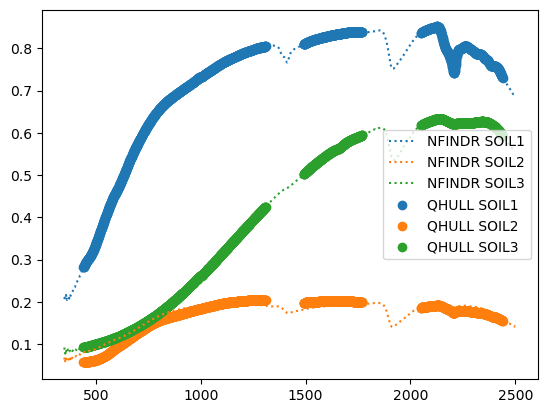

In [76]:
# Get endmembers for valid bands only
qhull_endmembers = qhull(cleaned_soil[:, good_idx], 2)
columns = [f'QHULL SOIL{i+1}' for i in range(qhull_endmembers.shape[0])]
qhull_soil_df_good = pd.DataFrame(qhull_endmembers.T, index=soil_wavelengths[good_idx], columns=columns)

fig, ax = plt.subplots()

nfindr_soil_df.plot(linestyle=':', ax=ax)
for col in ['QHULL SOIL1', 'QHULL SOIL2', 'QHULL SOIL3']:
    ax.scatter(qhull_soil_df_good.index, qhull_soil_df_good[col], label=col)
plt.legend()

In [77]:
# soil endmembers
endmembers = []
# replace soil endmember with typical soil
for col in qhull_soil_df_good.columns:
    endmembers.append(np.interp(soil_wavelengths[good_idx], qhull_soil_df_good.index, qhull_soil_df_good[col]))
endmembers = np.array(endmembers)

# Setup inputs, outputs, and other configurations
sum_to_one = endmembers.shape[0]
weighted_endmembers = np.vstack((endmembers.T, np.ones(endmembers.shape[0]) * sum_to_one))

# unmix mean spectra
df_unmelted = df_soil_group.pivot(index='Soil', columns='Wavelength', values='Reflectance')
transformed = df_unmelted.values.T[good_idx, :]

# Precompute ones array outside the loop
ones_array = np.full((1, transformed.shape[1]), sum_to_one)

# Combine weighted reflectance with ones_array using np.vstack
weightedReflectance = np.vstack((transformed, ones_array))

# Initialize fractions array with zeros
fractions_nnls = np.zeros((weighted_endmembers.shape[1], transformed.shape[1]), dtype=np.float32)
# Use vectorization where possible
for i in range(weightedReflectance.shape[1]):
    fractions_nnls[:, i], _ = nnls(weighted_endmembers, weightedReflectance[:, i])

fractions_nnls.sum(axis=0)

array([1.0228386, 1.074099 , 1.0670471, 1.0535156, 1.026322 , 1.0478166,
       0.9933874, 1.0337331, 1.0569215, 1.0708349, 1.0067997],
      dtype=float32)

In [93]:
def nan_filled(good_values, good_idx):
    arr = np.full(np.array(good_idx).shape, np.nan)
    arr[good_idx] = good_values
    return arr

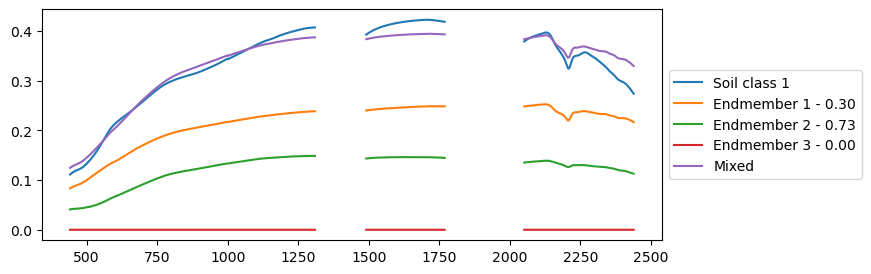

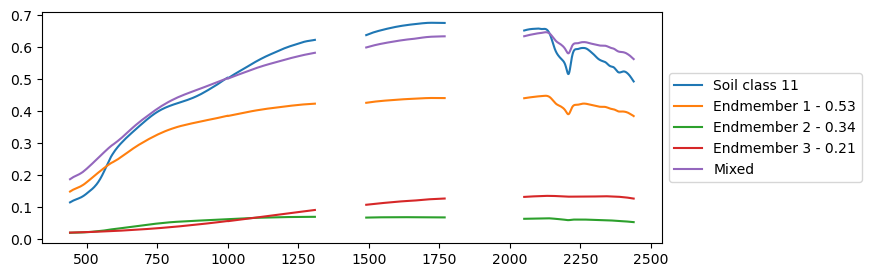

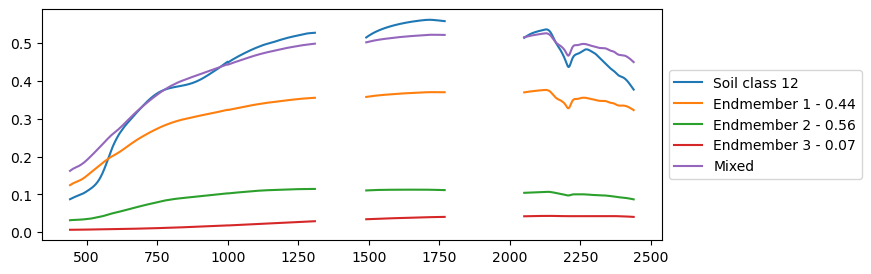

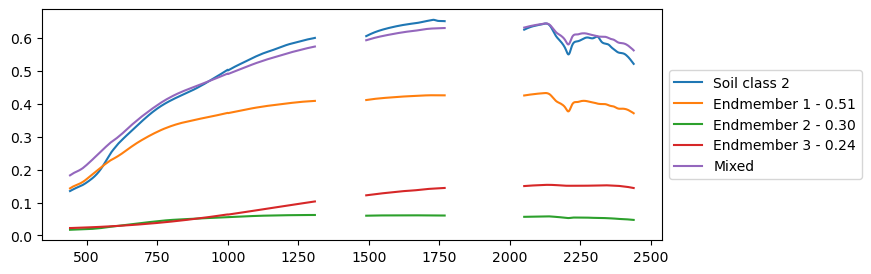

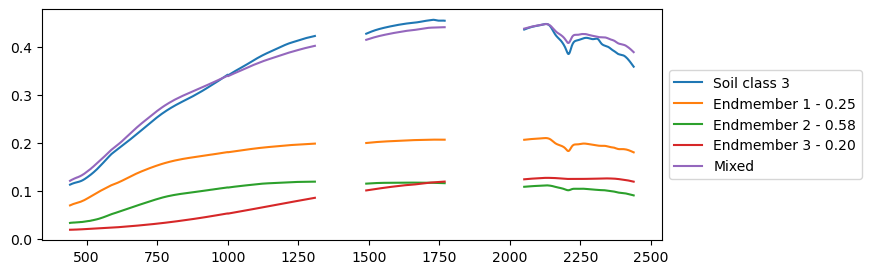

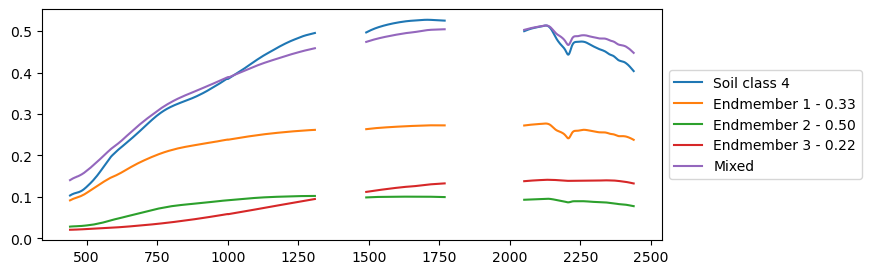

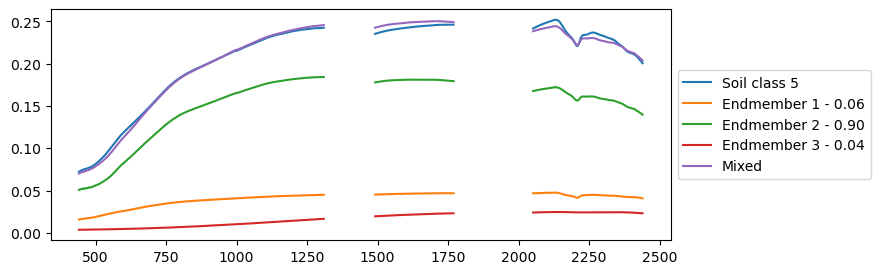

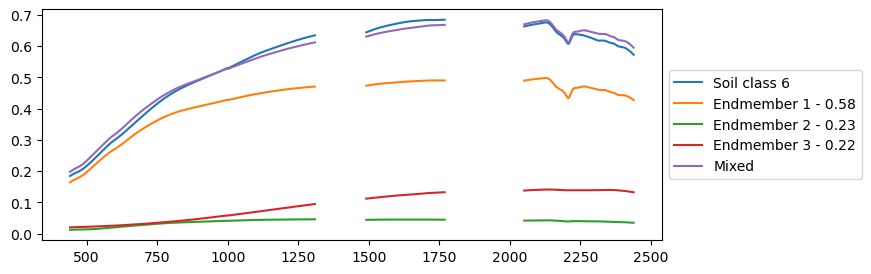

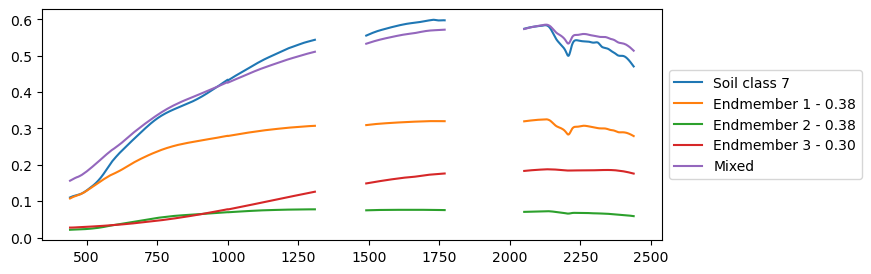

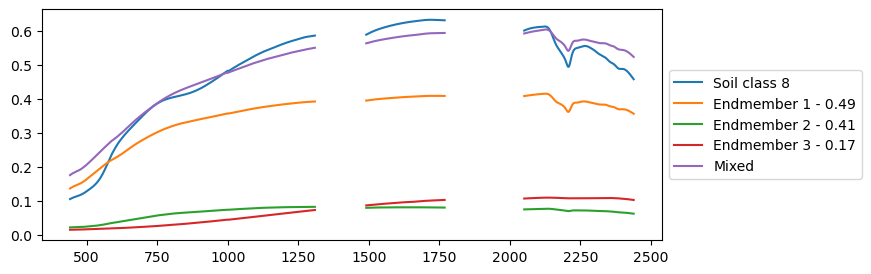

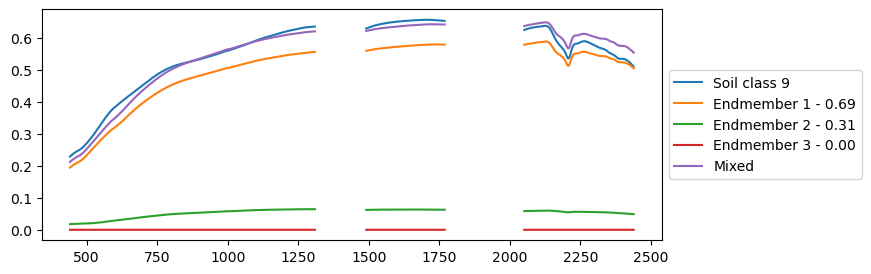

In [97]:
wavelengths = nan_filled(soil_wavelengths[good_idx], good_idx)

for idx in range(len(df_unmelted.index)):
    plt.figure(figsize=(8, 3))
    soil_type = df_unmelted.index[idx]
    E0 = endmembers.T
    plt.plot(wavelengths, nan_filled(df_unmelted.loc[soil_type].values[good_idx], good_idx), label=soil_type)
    for i in range(fractions_nnls.shape[0]):
        if i==0: mixed = fractions_nnls[i, idx]*E0[:,i]
        else: mixed+= fractions_nnls[i, idx]*E0[:,i]
        plt.plot(wavelengths, nan_filled(fractions_nnls[i, idx]*E0[:,i], good_idx), label=f'Endmember {i+1} - {fractions_nnls[i, idx]:0.2f}')
    plt.plot(wavelengths, nan_filled(mixed, good_idx), label='Mixed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))